# Project 2 — Scikit-learn baseline (regression)
**Cilj:** Jednostavan, jasan multivarijatni baseline (StandardScaler + Ridge). Izveštaj: RMSE i R² + scatter True vs Predicted.

In [34]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("Project2-PySpark").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")
print("Spark OK:", spark.version)


Spark OK: 3.5.1


In [35]:
# Import + split

import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

df = fetch_california_housing(as_frame=True).frame
X = df.drop(columns=["MedHouseVal"])
y = df["MedHouseVal"]

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)
df.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [36]:
# Baseline (simple first — Occam razor principle)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

baseline = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(random_state=42))
]).fit(Xtr, ytr)

yp0 = baseline.predict(Xte)
print("Baseline  RMSE=", round(sqrt(mean_squared_error(yte, yp0)), 4),
      " R2=", round(r2_score(yte, yp0), 4))

Baseline  RMSE= 0.7456  R2= 0.5758


In [37]:
# Pipeline (scaler + FE + Ridge) + CV i GridSearch

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import set_config
from math import sqrt

def add_custom_features(Xdf: pd.DataFrame) -> pd.DataFrame:
    Xnew = Xdf.copy()
    Xnew["Population_log1p"]   = np.log1p(Xnew["Population"])
    Xnew["IncomeRooms_inter"]  = Xnew["MedInc"] * Xnew["AveRooms"]
    return Xnew

# Key: feature_names_out is a callable that says what output names are
fe = FunctionTransformer(
    add_custom_features,
    feature_names_out=lambda tf, names: np.array(
        list(names) + ["Population_log1p", "IncomeRooms_inter"], dtype=object
    )
)

pipe = Pipeline([
    ("fe", fe),
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("ridge", Ridge(random_state=42))
])

param_grid = {"ridge__alpha": [0.1, 0.3, 1.0, 3.0, 10.0]}
cv = KFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(pipe, param_grid, scoring="neg_root_mean_squared_error", cv=cv, n_jobs=-1)

gs.fit(Xtr, ytr)

best = gs.best_estimator_
yp = best.predict(Xte)

rmse = sqrt(mean_squared_error(yte, yp))
r2   = r2_score(yte, yp)
print(f"Best alpha={gs.best_params_['ridge__alpha']}")
print(f"RMSE={rmse:.4f}  R2={r2:.4f}")

Best alpha=3.0
RMSE=0.7419  R2=0.5800


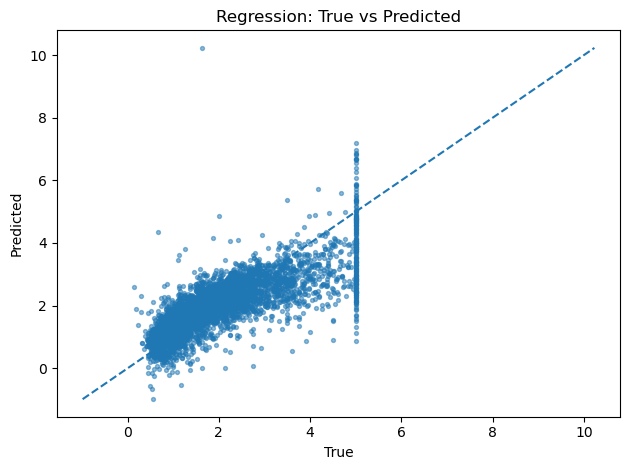

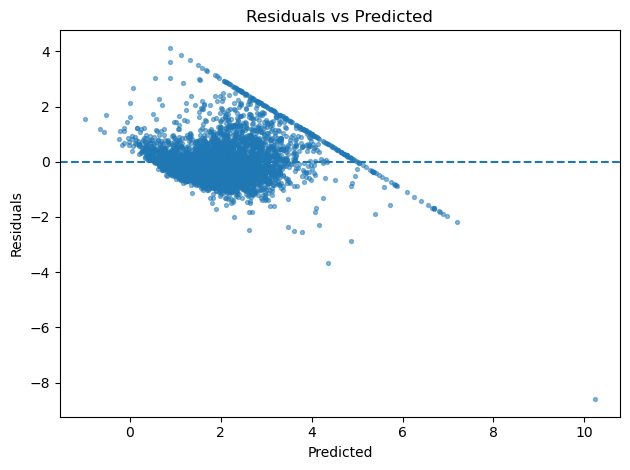

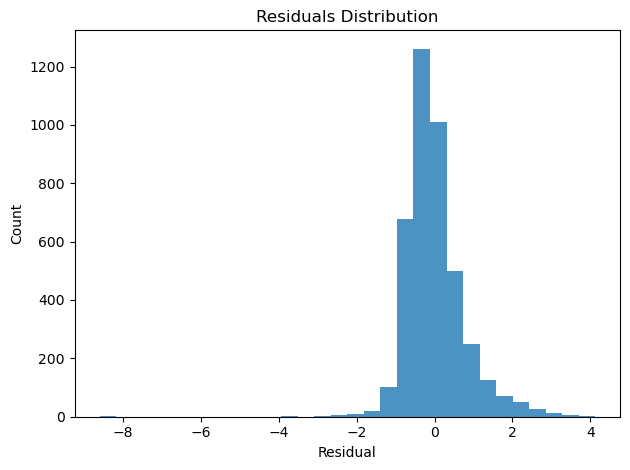

In [38]:
# Grafes: True vs Pred, Residuals vs Pred, histogram

import matplotlib.pyplot as plt

res = yte - yp

# True vs Pred
plt.scatter(yte, yp, s=8, alpha=0.5)
lims = [min(yte.min(), yp.min()), max(yte.max(), yp.max())]
plt.plot(lims, lims, "--")
plt.xlabel("True"); plt.ylabel("Predicted")
plt.title("Regression: True vs Predicted")
plt.tight_layout(); plt.show()

# Residuals vs Pred
plt.scatter(yp, res, s=8, alpha=0.5)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted"); plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.tight_layout(); plt.show()

# Histogram reziduala
plt.hist(res, bins=30, alpha=0.8)
plt.xlabel("Residual"); plt.ylabel("Count")
plt.title("Residuals Distribution")
plt.tight_layout(); plt.show()

In [39]:
# Permutation Importance – proračun

from sklearn.inspection import permutation_importance

pi = permutation_importance(
    best, Xte, yte,
    scoring="neg_root_mean_squared_error",
    n_repeats=20, random_state=42, n_jobs=-1
)

importances_mean = pi.importances_mean
importances_std  = pi.importances_std
feat_names = best.named_steps["fe"].get_feature_names_out()

# Sortiraj po važnosti
order = np.argsort(importances_mean)[::-1]

# Pregled top-15
for i in order[:15]:
    print(f"{feat_names[i]:25s}  mean={importances_mean[i]: .5f}  std={importances_std[i]: .5f}")

Latitude                   mean= 0.71751  std= 0.01182
Longitude                  mean= 0.68124  std= 0.01071
MedInc                     mean= 0.65579  std= 0.01044
AveBedrms                  mean= 0.20985  std= 0.00488
AveRooms                   mean= 0.19162  std= 0.00830
HouseAge                   mean= 0.01895  std= 0.00198
AveOccup                   mean= 0.00086  std= 0.00014
Population                 mean= 0.00002  std= 0.00007


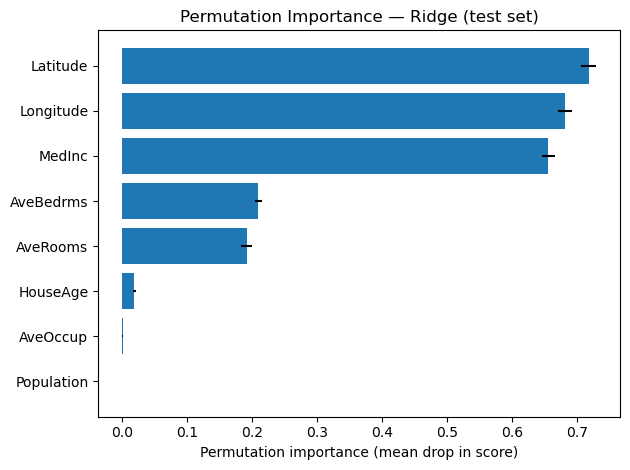

In [40]:
#Permutation Importance – graf

import matplotlib.pyplot as plt

top = 15
idx = order[:top][::-1]  # obrnut redosled za lep prikaz

plt.barh([feat_names[i] for i in idx],
         importances_mean[idx],
         xerr=importances_std[idx])
plt.xlabel("Permutation importance (mean drop in score)")
plt.title("Permutation Importance — Ridge (test set)")
plt.tight_layout()
plt.show()

In [41]:
spark.stop()